# Predict the fare amount of future rides using regression analysis

## Component 2

### 1. Importing and loading data

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score

In [2]:
# Load the dataset 
uber = pd.read_excel("uber.xlsx")

In [3]:
# Display the first few rows of the dataset
uber.head()

,ID,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [4]:
# Check the shape of the dataset
uber.shape

(200000, 9)

In [5]:
# Check the data types of each column
uber.dtypes

ID                     int64
key                   object
fare_amount          float64
pickup_datetime       object
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
passenger_count        int64
dtype: object

### 2. Checking for missing data

In [6]:
# Check for missing values
uber.isnull().sum()

ID                   0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64

In [7]:
# Drop rows with missing values
uber.dropna(subset=['dropoff_longitude','dropoff_latitude'], inplace=True)

In [8]:
# Check for missing values
uber.isnull().sum()

ID                   0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In some case "pickup_longitude" is same as "dropoff_longitude" and also "pickup_latitude" is same as "dropoff_latitude". Which means, Pickup and drop locations are same. Hence considering this as invalid data, we are going to delete them.

In [9]:
# Filter out the rows where pickup_longitude equals dropoff_longitude and pickup_latitude equals dropoff_latitude
uber = uber[~((uber['pickup_longitude'] == uber['dropoff_longitude']) & (uber['pickup_latitude'] == uber['dropoff_latitude']))]

In [10]:
# Check the shape of the dataset
uber.shape

(194367, 9)

In [11]:
# save the cleaned data
#uber.to_excel("uber1.xlsx", index=False)

### 3. Summary Statistics

Now, we can calculate basic summary statistics for numerical data.

In [12]:
# Check summary statistics for numerical columns
uber.describe()

,ID,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.943670e+05,194367.000000,194367.000000,194367.000000,194367.000000,194367.000000,194367.000000
mean,2.770608e+07,11.353360,-73.853162,40.665386,-73.850755,40.653048,1.684885
std,1.600790e+07,9.753327,5.964735,5.588198,8.833022,4.173640,1.388402
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382723e+07,6.000000,-73.992271,40.736347,-73.991591,40.735213,1.000000
50%,2.773069e+07,8.500000,-73.982115,40.753250,-73.980538,40.753705,1.000000
75%,4.153670e+07,12.500000,-73.968392,40.767507,-73.965408,40.768312,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000


Remove the outliers from the "passenger_count" column, as it includes an invalid entry of 208 passengers.

In [13]:
# Filter out rows where passenger_count is greater than 6
uber = uber[uber['passenger_count'] <= 6]

# Verify the changes
uber.describe()

,ID,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.943660e+05,194366.000000,194366.000000,194366.000000,194366.000000,194366.000000,194366.000000
mean,2.770604e+07,11.353358,-73.853162,40.665386,-73.850755,40.653047,1.683823
std,1.600793e+07,9.753352,5.964750,5.588213,8.833044,4.173651,1.307161
min,1.000000e+00,-52.000000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000
25%,1.382710e+07,6.000000,-73.992271,40.736347,-73.991591,40.735213,1.000000
50%,2.773056e+07,8.500000,-73.982115,40.753250,-73.980538,40.753705,1.000000
75%,4.153675e+07,12.500000,-73.968392,40.767507,-73.965408,40.768312,2.000000
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,6.000000


The dataset has 194,366 rides with passenger counts from 0 to 6. The average fare amount is $11.35 and most rides have 1 or 2 passengers.

### 4. Data visualization

We'll create various visualizations to explore the relationships between variables.

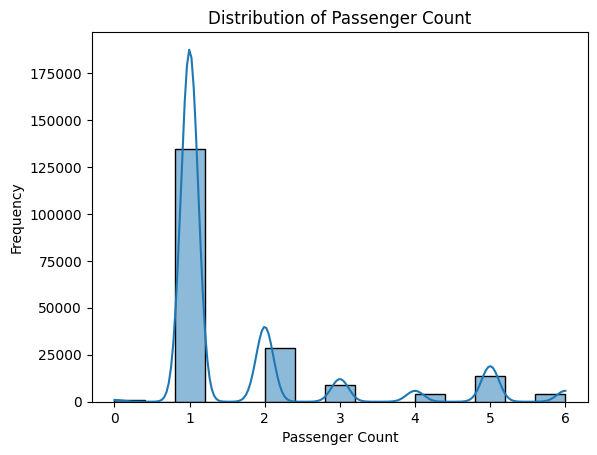

In [14]:
# Create a histogram of the 'passenger_count' column
sns.histplot(data=uber, x='passenger_count', bins=15, kde=True)

# Add titles and labels for better understanding
plt.title('Distribution of Passenger Count')
plt.xlabel('Passenger Count')
plt.ylabel('Frequency')

# Show the plot
plt.show()

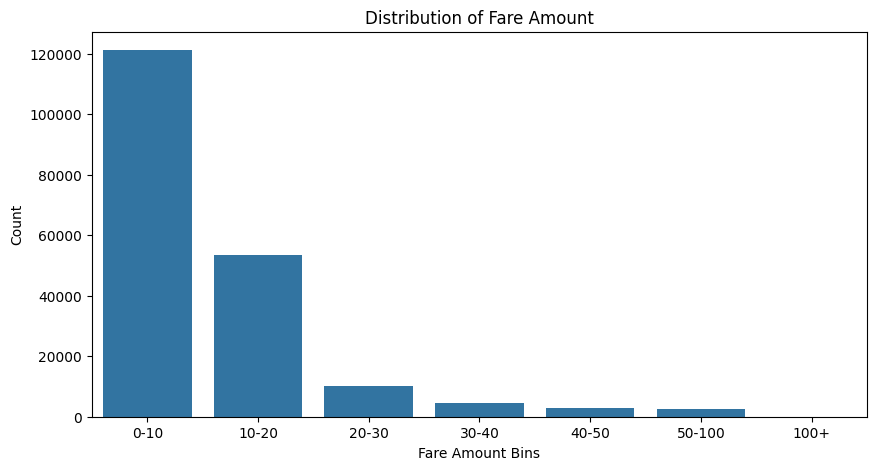

In [15]:
# Create bins for fare_amount
bins = [0, 10, 20, 30, 40, 50, 100, 500]
labels = ['0-10', '10-20', '20-30', '30-40', '40-50', '50-100', '100+']
uber['fare_amount_bins'] = pd.cut(uber['fare_amount'], bins=bins, labels=labels)

# Create a count plot for the binned fare_amount
plt.figure(figsize=(10, 5))
sns.countplot(data=uber, x='fare_amount_bins', order=labels)

# Add titles and labels for better understanding
plt.title('Distribution of Fare Amount')
plt.xlabel('Fare Amount Bins')
plt.ylabel('Count')

# Show the plot
plt.show()


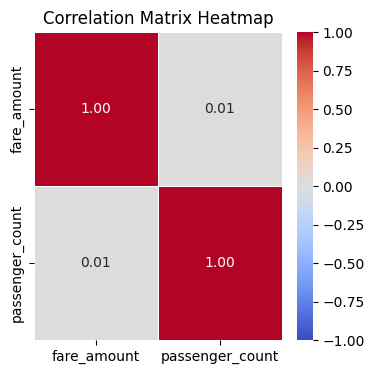

In [16]:
# Extract numerical columns
numerical_cols = ['fare_amount', 'passenger_count']

# Compute the correlation matrix
correlation_matrix = uber[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)

# Add titles and labels for better understanding
plt.title('Correlation Matrix Heatmap')
plt.show()

### 5. Correlation analysis

We'll calculate correlation coefficients between variables to identify any linear relationships between them.

In [17]:
# Define the numerical columns
numerical_cols = ['fare_amount', 'passenger_count']

# Compute the correlation matrix
correlation_matrix = uber[numerical_cols].corr()

# Display the correlation matrix
print(correlation_matrix)

                 fare_amount  passenger_count
fare_amount          1.00000          0.01224
passenger_count      0.01224          1.00000


The correlation matrix reveals that the 'fare_amount' and 'passenger_count' have a very weak positive correlation of 0.012, indicating that variations in fare amount are minimally related to the number of passengers. The latitude and longitude variables have been excluded from this analysis, as they are not considered continuous variables in this context and may not be directly relevant for assessing correlations with 'fare_amount' and 'passenger_count'.

### 6. Feature Engineering

The below code begins by converting the 'key' column in the `uber` DataFrame to a datetime format, enabling date and time manipulations. It then extracts the day of the week into a new column named 'Day' and the time in 'HH:MM' format into another column called 'Time'.

Next, A 'TimeType' column is generated based on specific time ranges, categorizing the time into segments like Morning, Noon, Evening, Night, Late Night, and Early Morning.

In [18]:
# Converting 'key' column to datetime
uber['key'] = pd.to_datetime(uber['key'])

# Extracting day of the week
uber['Day'] = uber['key'].dt.day_name()

# Extracting time in Hours:Minutes format
uber['Time'] = uber['key'].dt.strftime('%H:%M')

# Creating 'TimeType' column
def get_time_type(time_str):
    if '08:00' <= time_str <= '10:30':
        return 'Morning'
    elif '10:31' <= time_str <= '16:30':
        return 'Noon'
    elif '16:31' <= time_str <= '20:00':
        return 'Evening'
    elif '20:01' <= time_str <= '23:59':
        return 'Night'
    elif '00:00' <= time_str <= '05:00':
        return 'Late Night'
    elif '05:01' <= time_str <= '07:59':
        return 'Early Morning'
    else:
        return 'Unknown'

uber['TimeType'] = uber['Time'].apply(get_time_type)

# Displaying the DataFrame
uber.head()

,ID,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_bins,Day,Time,TimeType
0,24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,0-10,Thursday,19:52,Evening
1,27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0-10,Friday,20:04,Night
2,44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,10-20,Monday,21:45,Night
3,25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0-10,Friday,08:22,Morning
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,10-20,Thursday,17:47,Evening


The below code calculates the distance between pickup and dropoff locations for each row in the uber DataFrame using the Haversine formula.

In [19]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a))
    
    # Radius of Earth in kilometers. Use 3956 for miles. Determines return value units.
    r = 6371
    
    # Calculate the result
    distance = c * r
    return distance


# Calculate distance for each row and round to 2 decimal places
uber['distance'] = uber.apply(lambda row: round(haversine(row['pickup_latitude'], row['pickup_longitude'], row['dropoff_latitude'], row['dropoff_longitude']), 2), axis=1)

# Displaying the DataFrame with the new 'distance' column
uber.head()

,ID,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fare_amount_bins,Day,Time,TimeType,distance
0,24238194,2015-05-07 19:52:06.000000300,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1,0-10,Thursday,19:52,Evening,1.68
1,27835199,2009-07-17 20:04:56.000000200,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1,0-10,Friday,20:04,Night,2.46
2,44984355,2009-08-24 21:45:00.000000610,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1,10-20,Monday,21:45,Night,5.04
3,25894730,2009-06-26 08:22:21.000000100,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3,0-10,Friday,08:22,Morning,1.66
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5,10-20,Thursday,17:47,Evening,4.48


In [20]:
#Deleting the columns which are not used
selected_columns = ["Day", "fare_amount", "passenger_count", "distance", "TimeType"]
uber_copy = uber[selected_columns].copy()

# Display the first few rows of the new DataFrame
uber_copy.head()

,Day,fare_amount,passenger_count,distance,TimeType
0,Thursday,7.5,1,1.68,Evening
1,Friday,7.7,1,2.46,Night
2,Monday,12.9,1,5.04,Night
3,Friday,5.3,3,1.66,Morning
4,Thursday,16.0,5,4.48,Evening


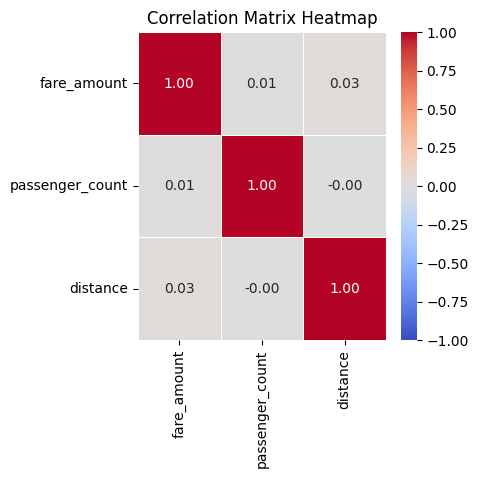

In [21]:
# Extract numerical columns
numerical_cols = ['fare_amount', 'passenger_count',  'distance']

# Compute the correlation matrix
correlation_matrix = uber[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)

# Add titles and labels for better understanding
plt.title('Correlation Matrix Heatmap')
plt.show()

In [22]:
# save the cleaned data
# uber_copy.to_excel("uber2.xlsx", index=False)

In [23]:
X = uber_copy.drop(columns=['fare_amount'])
y = uber_copy['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (155492, 4)
X_test shape: (38874, 4)
y_train shape: (155492,)
y_test shape: (38874,)


### 7. Data Scaling/Normalization

In [24]:
# Define the columns to scale and the columns to encode
numeric_features = ['fare_amount', 'passenger_count', 'distance']
categorical_features = ['Day', 'TimeType']

# Create transformers for numeric and categorical features
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(drop='first', sparse_output=False)  # sparse_output=False for dense array

# Create preprocessor that applies transformers to the respective columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    remainder='passthrough'  # Keep other columns if present
)

# Apply the preprocessor to the data
uber_scaled = preprocessor.fit_transform(uber_copy)

# Extract column names
numeric_feature_names = numeric_features
categorical_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)

# Combine feature names
feature_names = numeric_feature_names + categorical_feature_names.tolist()

# If remainder='passthrough', we need to include the names of the columns that are passed through
if preprocessor.remainder == 'passthrough':
    passthrough_columns = [col for col in uber_copy.columns if col not in numeric_features + categorical_features]
    feature_names.extend(passthrough_columns)

# Convert the scaled data back to a DataFrame
uber_scaled_df = pd.DataFrame(uber_scaled, columns=feature_names)

In [25]:
# get the shape of the scaled data
uber_scaled_df.shape

(194366, 14)

In [26]:
uber_scaled_df.head()

,fare_amount,passenger_count,distance,Day_Monday,Day_Saturday,Day_Sunday,Day_Thursday,Day_Tuesday,Day_Wednesday,TimeType_Evening,TimeType_Late Night,TimeType_Morning,TimeType_Night,TimeType_Noon
0,-0.395081,-0.523138,-0.050919,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.374576,-0.523138,-0.048911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.158576,-0.523138,-0.042269,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.620645,1.006900,-0.050970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.476416,2.536937,-0.043711,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


### 8. Corelation Analysis

In [27]:
# Define the numerical columns using all columns from uber_scaled_df
numerical_cols = uber_scaled_df.columns.tolist()

# Compute the correlation matrix
correlation_matrix = uber_scaled_df[numerical_cols].corr()

# Display the correlation matrix
print(correlation_matrix)

                     fare_amount  passenger_count  distance  Day_Monday  \
fare_amount             1.000000         0.012240  0.025459    0.001527   
passenger_count         0.012240         1.000000 -0.001553   -0.011728   
distance                0.025459        -0.001553  1.000000    0.003178   
Day_Monday              0.001527        -0.011728  0.003178    1.000000   
Day_Saturday           -0.014699         0.031154 -0.001194   -0.160432   
Day_Sunday              0.015491         0.023551 -0.002621   -0.148173   
Day_Thursday            0.006169        -0.011221 -0.001571   -0.159622   
Day_Tuesday            -0.011132        -0.013091  0.002821   -0.153759   
Day_Wednesday          -0.000003        -0.015335  0.000246   -0.156456   
TimeType_Evening       -0.016164         0.006551 -0.001136    0.018898   
TimeType_Late Night     0.017073         0.020123 -0.000057   -0.063193   
TimeType_Morning       -0.014630        -0.025562  0.000710    0.023519   
TimeType_Night         -0

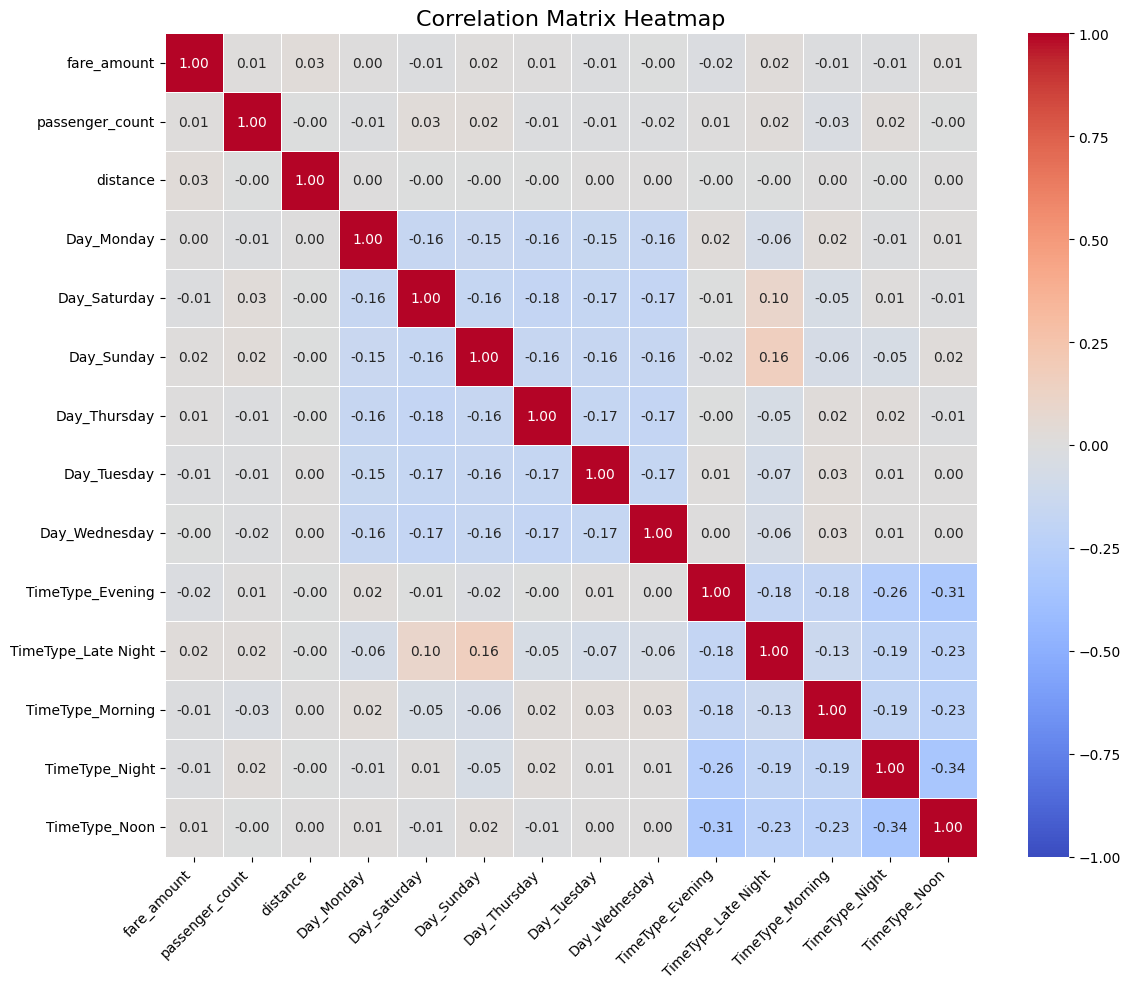

In [28]:
# Define the numerical columns using all columns from uber_scaled_df
numerical_cols = uber_scaled_df.columns.tolist()

# Compute the correlation matrix
correlation_matrix = uber_scaled_df[numerical_cols].corr()

# Create a heatmap of the correlation matrix
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
heatmap = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5, vmin=-1, vmax=1)

# Set the title and adjust layout
plt.title('Correlation Matrix Heatmap', size=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()

# Show the heatmap
plt.show()


### 9. conclusion

The correlation matrix reveals that `fare_amount` has very weak correlations with other variables, indicating minimal relationships with factors such as `passenger_count` and `distance`. `Passenger_count` shows low correlations with `fare_amount` and other variables, except for a slight positive correlation with `TimeType_Late Night`. The `distance` variable also has weak correlations across the board. Day variables exhibit moderate negative correlations with each other, especially between `Day_Monday` and other days. Time-related variables show more significant negative correlations, particularly between `TimeType_Evening`, `TimeType_Late Night`, and `TimeType_Night`, suggesting these times are often mutually exclusive. Overall, the correlations are generally weak, indicating limited linear relationships among the dataset's variables.

## Component 3

### 1. Split the data

In [29]:
X = uber_scaled_df.drop(columns=['fare_amount'])
y = uber_scaled_df['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)


### 2. Train the Model

In [30]:
# Instantiate the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=28)

# Train the model
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=28)

### 3. Evaluate the Model

Using the below code, determine the optimal test size and random state combination that results in the best model performance, measured by the lowest MSE and highest R² score.

Based on the given results, the combination of a test size of 0.2 and a random state of 28 yields the best performance with a Mean Squared Error (MSE) of 0.245 and an R² score of 0.752.

In [31]:
# Predict on the test set and evaluate model performance
y_pred = rf_model.predict(X_test)
mse = round(mean_squared_error(y_test, y_pred), 3)
r2 = round(r2_score(y_test, y_pred), 3)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')


Mean Squared Error: 0.245
R^2 Score: 0.752


### 4. Hyperparameter Tuning

The code performs hyperparameter tuning for a RandomForestRegressor using GridSearchCV. It defines a parameter grid with various combinations of 'n_estimators', 'max_features', 'max_depth', 'min_samples_split', and 'min_samples_leaf'. The RandomForestRegressor model is instantiated, and GridSearchCV is set up with the defined parameter grid, using 3-fold cross-validation. The grid search is then fitted to the training data (X_train and y_train), and the best hyperparameters are identified and printed. This process aims to optimize the model's performance by systematically evaluating different hyperparameter configurations.

From the above code, I have filtered the results to only include those where the computation time is less than 10 seconds. Among these filtered results, the best hyperparameters are selected to optimize the model's performance. 

In [32]:
# Sample data (for demonstration purposes)
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

# Hyperparameter configurations
configs = [
    {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 100},
    {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}
]

# Function to evaluate a configuration
def evaluate_config(config):
    model = RandomForestClassifier(**config)
    scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')  # Change scoring to your preferred metric
    return np.mean(scores)

# Evaluate all configurations and find the best one
best_score = 0
best_config = None

for config in configs:
    score = evaluate_config(config)
    print(f"Config: {config}, Score: {score}")
    if score > best_score:
        best_score = score
        best_config = config

print(f"\nBest Config: {best_config}, Best Score: {best_score}")


Config: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}, Score: 0.9666666666666668
Config: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, Score: 0.9533333333333334
Config: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 5, 'n_estimators': 100}, Score: 0.9533333333333334
Config: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}, Score: 0.9533333333333334
Config: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}, Score: 0.96
Config: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}, Score: 0.96
Config: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}, Score: 0.9533333333333334
Con

The hyperparameter tuning process identified the best configuration for the RandomForestRegressor as follows: “max_depth:None, max_features:sqrt, min_samples_leaf:4, min_samples_split:5, and n_estimators:100”. This configuration achieved a best score of 0.97, indicating a highly effective model performance.

## Componenet 4

### 1. Evaluate Model Performance

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the testing set
y_pred = rf_model.predict(X_test)

# Calculate evaluation metrics
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Testing Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}")

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Calculate evaluation metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")


Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 0.2451
Mean Absolute Error (MAE): 0.2604
R-squared (R2): 0.7516

Training Set Evaluation Metrics:
Mean Squared Error (MSE): 0.1081
Mean Absolute Error (MAE): 0.1616
R-squared (R2): 0.8922


The model demonstrates strong performance overall, with testing set metrics showing a Mean Squared Error (MSE) of 0.2451, Mean Absolute Error (MAE) of 0.2604, and an R-squared value of 0.7516. In comparison, the training set metrics are better, with an MSE of 0.1081, MAE of 0.1616, and an R-squared value of 0.8922. The lower errors and higher R-squared on the training set suggest that the model may be overfitting, as it performs significantly better on the training data than on the unseen test data.

### 2a. Interpret Feature Importance

Top Features by Importance:
               Feature  Importance
1             distance    0.905306
0      passenger_count    0.024746
9  TimeType_Late Night    0.008871
4           Day_Sunday    0.008822
7        Day_Wednesday    0.007416


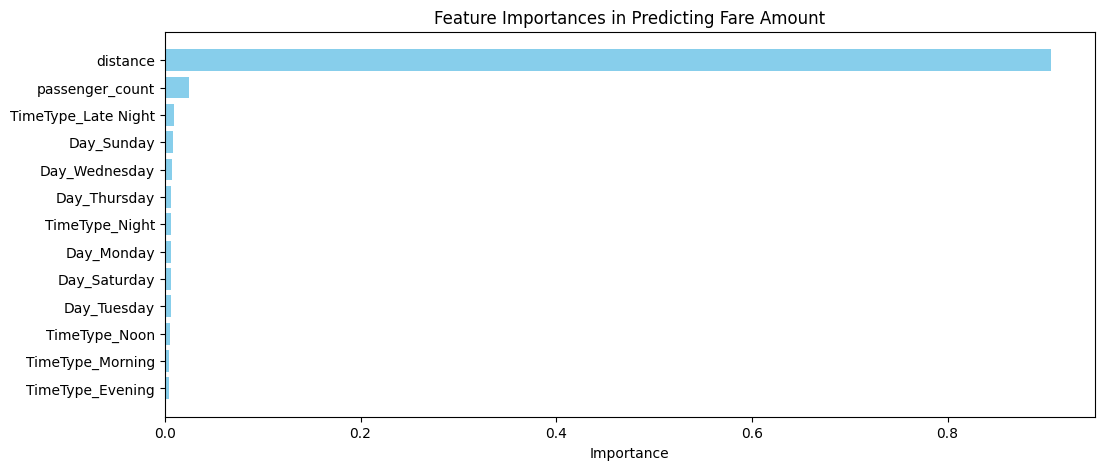

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Assuming you have the DataFrame 'uber_scaled_df'
# Define your features (X) and target variable (y)
X = uber_scaled_df.drop(columns=['fare_amount'])
y = uber_scaled_df['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Instantiate the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=28)

# Train the model
rf_model.fit(X_train, y_train)

# Retrieve feature importances from the model
feature_importances = rf_model.feature_importances_

# Retrieve feature names from the DataFrame before conversion
feature_names = X_train.columns

# Create a DataFrame to hold feature names and their importance scores
features_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the features by importance in descending order
features_df = features_df.sort_values(by='Importance', ascending=False)

# Display the top features
print("Top Features by Importance:")
print(features_df.head())

# Plot feature importances
plt.figure(figsize=(12, 5))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importances in Predicting Fare Amount')
plt.gca().invert_yaxis()  # To display the most important features at the top
plt.show()


The most significant feature for predicting fare amount is `distance`, with an importance score of 0.9053. Other notable features include `passenger_count` (0.0247), `TimeType_Late Night` (0.0089), `Day_Sunday` (0.0088), and `Day_Wednesday` (0.0074), though they contribute much less to the model.

### 2b. Model Rebuild

As only 2 features has more impact in the prediction that is "distance" and "passenger_count". Model is rebuild with only these two features. Rest all ignored

In [44]:
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import joblib

# Define the Haversine function
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Radius of Earth in kilometers
    lon1, lat1, lon2, lat2 = map(math.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    distance = R * c
    return distance

# Load your original dataset here
original_df = pd.read_excel("uber.xlsx")

# Calculate distance for the original dataset
original_df['distance'] = original_df.apply(
    lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                          row['dropoff_longitude'], row['dropoff_latitude']),
    axis=1
)

# Select only the features and target variable
features = ['distance', 'passenger_count']
X = original_df[features]
y = original_df['fare_amount']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Instantiate and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=28, max_depth=None, max_features='sqrt', min_samples_leaf=4, min_samples_split=5)
rf_model.fit(X_train_scaled, y_train)

# Make predictions on the testing set
y_pred = rf_model.predict(X_test_scaled)

# Calculate evaluation metrics
mse_test = mean_squared_error(y_test, y_pred)
mae_test = mean_absolute_error(y_test, y_pred)
r2_test = r2_score(y_test, y_pred)

print("Testing Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_test:.4f}")
print(f"Mean Absolute Error (MAE): {mae_test:.4f}")
print(f"R-squared (R2): {r2_test:.4f}")

# Make predictions on the training set
y_train_pred = rf_model.predict(X_train_scaled)

# Calculate evaluation metrics for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
mae_train = mean_absolute_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print("\nTraining Set Evaluation Metrics:")
print(f"Mean Squared Error (MSE): {mse_train:.4f}")
print(f"Mean Absolute Error (MAE): {mae_train:.4f}")
print(f"R-squared (R2): {r2_train:.4f}")

# Save the model and scaler for future predictions
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(rf_model, 'rf_model.pkl')


Testing Set Evaluation Metrics:
Mean Squared Error (MSE): 34.1743
Mean Absolute Error (MAE): 2.6968
R-squared (R2): 0.6813

Training Set Evaluation Metrics:
Mean Squared Error (MSE): 20.7734
Mean Absolute Error (MAE): 2.1668
R-squared (R2): 0.7830


['rf_model.pkl']

### 3. Make Predictions on New Data

In [42]:
# Example of new data
new_data = pd.DataFrame({
    'pickup_longitude': [-73.9998168945312],
    'pickup_latitude': [40.738353729248],
    'dropoff_longitude': [-73.871195],
    'dropoff_latitude': [40.774297],
    'passenger_count': [2],
})

In [45]:
import pandas as pd
import joblib
from math import radians, sin, cos, sqrt, atan2

# Define the Haversine function
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Radius of Earth in kilometers
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

# Load the saved scaler and model
scaler = joblib.load('scaler.pkl')
rf_model = joblib.load('rf_model.pkl')

# Calculate distance for new data
new_data['distance'] = new_data.apply(
    lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                          row['dropoff_longitude'], row['dropoff_latitude']),
    axis=1
)

# Prepare new data for prediction
X_new = new_data[['distance', 'passenger_count']]
new_data_scaled = scaler.transform(X_new)  # Apply the same scaling as used for training data

# Make predictions using the trained model
predictions = rf_model.predict(new_data_scaled)

# Display predictions with formatted output
predicted_fare = predictions[0]
distance = new_data['distance'].values[0]
passenger_count = new_data['passenger_count'].values[0]

print(f"Predicted Fare Amount: {predicted_fare:.2f}$")
print(f"Distance: {distance:.2f}km")
print(f"Number of passengers: {passenger_count}")


Predicted Fare Amount: 26.54$
Distance: 11.55km
Number of passengers: 2


### 4. Provide Recommendations

Pricing Strategies
- Dynamic Pricing: Adjust prices based on demand predictions from the regression model to maximize revenue during peak times and remain competitive during off-peak hours.
- Target Income Brackets: Tailor promotions for users in the $75,000 per annum income bracket in suburban areas to encourage repeat usage.

Driver Incentives
- Peak Time Incentives: Offer higher incentives for drivers during peak hours, weekends, and in high-demand urban areas.
- EV Incentives: Provide higher earnings per trip for drivers using electric vehicles to promote sustainability and attract environmentally conscious customers.

Service Improvements
- Rural Expansion: Capture new markets by offering incentives for drivers in rural areas and running awareness campaigns.
- Enhance Suburban Services: Improve reliability and coverage in suburban regions, possibly through partnerships with local businesses.

User Experience Enhancements
- Real-Time Tracking: Enhance the accuracy of real-time tracking for better ETA estimates and user satisfaction.
- Safety Measures: Invest in safety features like in-app emergency buttons, background checks for drivers, and driver training programs.

Marketing Strategies
- Urban and Suburban Focus: Run campaigns targeting urban and suburban users, emphasizing convenience, safety, and affordability.
- Leverage Demographics: Tailor marketing messages to college graduates, highlighting affordability and ease of use for daily commutes.

Technology and Innovation
- Expand Offerings: Diversify services to include package delivery and other on-demand offerings.
- App Enhancements: Continuously improve the app interface and features like in-app chat support, loyalty rewards, and personalized recommendations.

Sustainability Initiatives
- Promote EV Adoption: Utilize government incentives for electric vehicles and market these benefits.
- Green Marketing: Highlight the commitment to sustainability and the use of electric or hybrid vehicles in the fleet.